# WRF / SCI Precipitation Comparison
__Author:__ Pat McCornack

__Date:__ 11-22-24

__Description:__  
This notebook compares WRF model outputs with observational data collected at Sauces Canyon (SAUC) and Upper Embudo Canyon (UPEM) by weather stations installed by Chris Still.

__Credits:__  
This is a modified version of cis.1.airt.compare.ipynb written by Charles Jones. 

__Note:__  
This script was designed to run on the server hosting the outputs of the WRF model, and the filepaths reflect that. 

In [1]:
import os 
import glob 

import numpy as np
import pandas as pd
import xarray as xr
import netCDF4


import matplotlib.pyplot as plt
from   matplotlib.lines import Line2D

# Prepare Data 

## Prepare Terrain/Land Mask

In [2]:
#  Open geogrid file
file     = '/home/sbarc/wrf/wrf401/sbareg/geo_em.d04.nc'
ds       = xr.open_dataset(file)
ds

#   read one 2DVar file to get coordinates
path     = '/home/sbarc/wrf/wrf401/sbareg/'
yr1      = 1988
m        = 0
files    = sorted(glob.glob(path + str(yr1+m) + '/wrfout_d04_2DVar_*.nc'))
f2       = xr.open_dataset(files[m])

#   creat xarray
terrain  = xr.DataArray(ds['HGT_M'][0,:,:].values, dims =("south_north","west_east"), name="terrain",     
                    coords={"XLAT":f2['XLAT'],"XLONG":f2['XLONG']},
                    attrs ={'terrain':'elevation (m)'})
#   creat landmask
landmask = xr.DataArray(ds['LANDMASK'][0,:,:].values, dims =("south_north","west_east"), name="landmask",     
                    coords={"XLAT":f2['XLAT'],"XLONG":f2['XLONG']},
                    attrs ={'landmask':'landmask (m)'})

In [3]:
f2

<xarray.Dataset>
Dimensions:   (Time: 24, bottom_top: 54, south_north: 234, west_east: 258)
Coordinates:
    XLAT      (south_north, west_east) float32 ...
    XLONG     (south_north, west_east) float32 ...
Dimensions without coordinates: Time, bottom_top, south_north, west_east
Data variables:
    HGT       (south_north, west_east) float32 ...
    Times     (Time) |S19 ...
    Q2        (Time, south_north, west_east) float32 ...
    T2        (Time, south_north, west_east) float32 ...
    TH2       (Time, south_north, west_east) float32 ...
    PSFC      (Time, south_north, west_east) float32 ...
    U10       (Time, south_north, west_east) float32 ...
    V10       (Time, south_north, west_east) float32 ...
    FGDP      (Time, south_north, west_east) float32 ...
    DFGDP     (Time, south_north, west_east) float32 ...
    VDFG      (Time, south_north, west_east) float32 ...
    RAINNC    (Time, south_north, west_east) float32 ...
    I_RAINNC  (Time, south_north, west_east) int32 ...
    CLDFRA    (Time, bottom_top, south_north, west_east) float32 ...
    LWUPB     (Time, south_north, west_east) float32 ...
    LWDNB     (Time, south_north, west_east) float32 ...
    SWUPB     (Time, south_north, west_east) float32 ...
    SWDNB     (Time, south_north, west_east) float32 ...
    UST       (Time, south_north, west_east) float32 ...
    HFX       (Time, south_north, west_east) float32 ...
    QFX       (Time, south_north, west_east) float32 ...
    LH        (Time, south_north, west_east) float32 ...
    GRDFLX    (Time, south_north, west_east) float32 ...
    PBLH      (Time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V4.0.1 MODEL
    START_DATE:                      1987-07-01_00:00:00
    SIMULATION_START_DATE:           1987-07-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        259
    SOUTH-NORTH_GRID_DIMENSION:      235
    BOTTOM-TOP_GRID_DIMENSION:       55
    DX:                              1000.0
    DY:                              1000.0
    AERCU_OPT:                       0
    AERCU_FCT:                       1.0
    IDEAL_CASE:                      0
    DIFF_6TH_SLOPEOPT:               0
    AUTO_LEVELS_OPT:                 2
    DIFF_6TH_THRESH:                 0.1
    DZBOT:                           50.0
    DZSTRETCH_S:                     1.3
    DZSTRETCH_U:                     1.1
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    DIFF_OPT:                        2
    KM_OPT:                          4
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      6
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               5
    SF_SURFACE_PHYSICS:              4
    BL_PBL_PHYSICS:                  5
    CU_PHYSICS:                      0
    SF_LAKE_PHYSICS:                 0
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      1
    GRID_FDDA:                       0
    GFDDA_INTERVAL_M:                0
    GFDDA_END_H:                     0
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 2
    USE_THETA_M:                     1
    GWD_OPT:                         0
    SF_URBAN_PHYSICS:                0
    SF_SURFACE_MOSAIC:               0
    SF_OCEAN_PHYSICS:                0
    SHCU_PHYSICS:                    0
    MFSHCONV:                        0
    FEEDBACK:                        1
    SMOOTH_OPTION:                   0
    SWRAD_SCAT:                      1.0
    W_DAMPING:                       0
    DT:                              3.3333333
    RADT:                            10.0
    BLDT:      

## Select Domain to Crop

In [4]:
#   Select domain to crop - e.g. subset to 
i1 = 20
i2 = 135
j1 = 50

j2 = 199


## Create list of dates

In [5]:
yr1      = 1988
yr2      = 2019
nyrs     = yr2 - yr1  + 1
dstart   = str(yr1-1) + '-07-01'
dend     = str(yr2)   + "-06-30"
caldata  = pd.date_range(start=dstart,end=dend,freq="D")
caldata

DatetimeIndex(['1987-07-01', '1987-07-02', '1987-07-03', '1987-07-04',
               '1987-07-05', '1987-07-06', '1987-07-07', '1987-07-08',
               '1987-07-09', '1987-07-10',
               ...
               '2019-06-21', '2019-06-22', '2019-06-23', '2019-06-24',
               '2019-06-25', '2019-06-26', '2019-06-27', '2019-06-28',
               '2019-06-29', '2019-06-30'],
              dtype='datetime64[ns]', length=11688, freq='D')

## Read data

In [6]:
#  Read data
path  = '/home/sbarc/wrf/wrf401/sbareg/sbcwrf/dly_prec/'
files = sorted(glob.glob(path + 'wrf.dlytotal.precip.*.nc'))

mlat  = i2 - i1 + 1
mlon  = j2 - j1 + 1
mtot  = len(caldata)
rh  = np.zeros((mtot,mlat,mlon))

for m in range(nyrs):
    print (files[m])
    f2  = xr.open_dataarray(files[m])
    tot = len(f2['times'].values)
    tmp = str(f2['times'][0].values)
    tmp = tmp.split('T')
    xd1 = tmp[0]
    tmp = str(f2['times'][tot-1].values)
    tmp = tmp.split('T')
    xd2 = tmp[0]
    id1 = np.squeeze(np.where(caldata == xd1))
    id2 = np.squeeze(np.where(caldata == xd2)  )
    rh[id1:id2+1,:,:] = f2[:,i1:i2+1,j1:j2+1]
    

/home/sbarc/wrf/wrf401/sbareg/sbcwrf/dly_prec/wrf.dlytotal.precip.1988.nc
/home/sbarc/wrf/wrf401/sbareg/sbcwrf/dly_prec/wrf.dlytotal.precip.1989.nc
/home/sbarc/wrf/wrf401/sbareg/sbcwrf/dly_prec/wrf.dlytotal.precip.1990.nc
/home/sbarc/wrf/wrf401/sbareg/sbcwrf/dly_prec/wrf.dlytotal.precip.1991.nc
/home/sbarc/wrf/wrf401/sbareg/sbcwrf/dly_prec/wrf.dlytotal.precip.1992.nc
/home/sbarc/wrf/wrf401/sbareg/sbcwrf/dly_prec/wrf.dlytotal.precip.1993.nc
/home/sbarc/wrf/wrf401/sbareg/sbcwrf/dly_prec/wrf.dlytotal.precip.1994.nc
/home/sbarc/wrf/wrf401/sbareg/sbcwrf/dly_prec/wrf.dlytotal.precip.1995.nc
/home/sbarc/wrf/wrf401/sbareg/sbcwrf/dly_prec/wrf.dlytotal.precip.1996.nc
/home/sbarc/wrf/wrf401/sbareg/sbcwrf/dly_prec/wrf.dlytotal.precip.1997.nc
/home/sbarc/wrf/wrf401/sbareg/sbcwrf/dly_prec/wrf.dlytotal.precip.1998.nc
/home/sbarc/wrf/wrf401/sbareg/sbcwrf/dly_prec/wrf.dlytotal.precip.1999.nc
/home/sbarc/wrf/wrf401/sbareg/sbcwrf/dly_prec/wrf.dlytotal.precip.2000.nc
/home/sbarc/wrf/wrf401/sbareg/sbcwrf/d

In [7]:
np.shape(rh)

(11688, 116, 150)

## Create Data Arrays 

In [8]:
#  crop terrain and landmask
terrain  = terrain[i1:i2+1,j1:j2+1]
landmask = landmask[i1:i2+1,j1:j2+1]

In [9]:
landmask.shape

(116, 150)

In [10]:
# create xarray
drh = xr.DataArray(rh, dims =("times","south_north","west_east"), name="total precip",     
                     coords={"times":caldata,"XLAT":terrain['XLAT'],"XLONG":terrain['XLONG']},
                     attrs ={'total precip':'daily total precip'})
drh

<xarray.DataArray 'total precip' (times: 11688, south_north: 116, west_east: 150)>
array([[[1.09554990e-02, 2.01208522e-02, 2.27430534e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.84405068e-02, 2.10740145e-02, 2.40881622e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.76692569e-02, 2.32870503e-02, 2.42312851e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [3.14440457e-24, 3.05988295e-27, 4.06426550e-26, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.89799046e-25, 2.01853912e-25, 9.53469852e-26, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.88579337e-25, 6.50189026e-27, 1.10070866e-26, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[2.24894956e-02, 3.82968374e-02, 4.04172949e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.47732268e-02, 3.76716517e-02, 4.01172116e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.22874486e-02, 3.86306085e-02, 3.93853560e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [4.40053154e+02, 4.34138161e+02, 4.30444656e+02, ...,
         1.06625263e+03, 1.06931916e+03, 1.04980113e+03],
        [4.39350304e+02, 4.39884892e+02, 4.36839241e+02, ...,
         9.60343906e+02, 9.71173546e+02, 9.71052017e+02],
        [4.32615131e+02, 4.38629528e+02, 4.37310757e+02, ...,
         8.67227592e+02, 8.88125496e+02, 9.08864374e+02]],

       [[3.71594643e+02, 3.76362473e+02, 3.86706635e+02, ...,
         3.50191097e+02, 3.59318211e+02, 3.55136200e+02],
        [3.74708054e+02, 3.79536560e+02, 3.91114288e+02, ...,
         3.47192287e+02, 3.56145260e+02, 3.54311810e+02],
        [3.82310234e+02, 3.87628738e+02, 3.95514580e+02, ...,
         3.43965015e+02, 3.57431168e+02, 3.60728870e+02],
        ...,
        [4.40053154e+02, 4.34138161e+02, 4.30444656e+02, ...,
         1.06625263e+03, 1.06931916e+03, 1.04980113e+03],
        [4.39350304e+02, 4.39884892e+02, 4.36839241e+02, ...,
         9.60343906e+02, 9.71173546e+02, 9.71052017e+02],
        [4.32615131e+02, 4.38629528e+02, 4.37310757e+02, ...,
         8.67227592e+02, 8.88125496e+02, 9.08864374e+02]]])
Coordinates:
  * times    (times) datetime64[ns] 1987-07-01 1987-07-02 ... 2019-06-30
    XLAT     (south_north, west_east) float32 ...
    XLONG    (south_north, west_east) float32 ...
Dimensions without coordinates: south_north, west_east
Attributes:
    total precip:  daily total precip

## Check Data

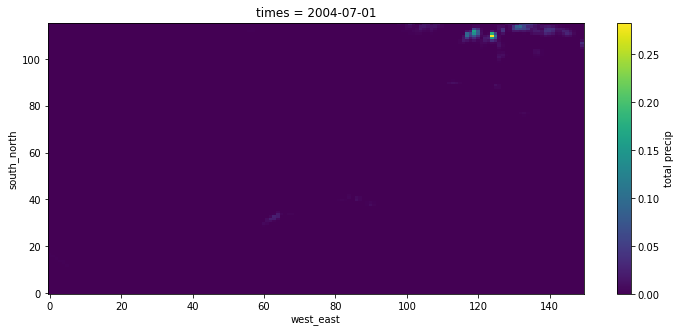

In [11]:
#### Plot WRF air temps for specific date ####
plt.figure(figsize=[12., 5.])
m  = np.squeeze(np.where(caldata == '2004-07-1'))
drh[m,:,:].plot()

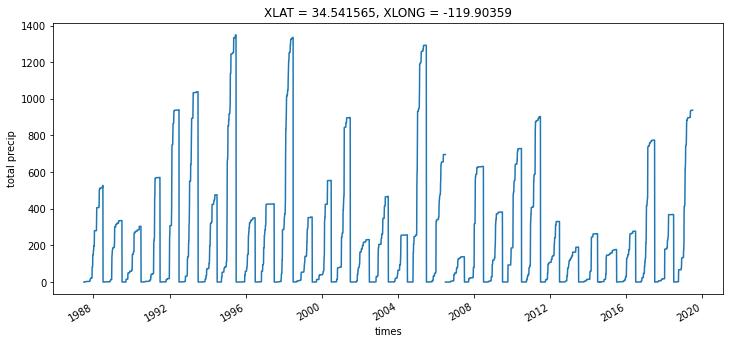

In [12]:
#### Plot WRF air temp timeseries for given coordinate ####
plt.figure(figsize=[12., 5.])
drh[:,100,80].plot()

## Fill in missing/suspicious files 

In [13]:
# These are missing for rh, not sure if they're missing for RH

#idx = np.squeeze(np.where(caldata == '2006-07-01'))
#m   = 0.5 * (drh[idx+1,:,:] - drh[idx-1,:,:])
#tmp = drh[idx-1,:,:] + m 
#drh[idx,:,:] = tmp.values

#idx = np.squeeze(np.where(caldata == '2014-08-18'))
#m   = 0.5 * (drh[idx+1,:,:] - drh[idx-1,:,:])
#tmp = drh[idx-1,:,:] + m 
#drh[idx,:,:] = tmp.values

#idx = np.squeeze(np.where(caldata == '2017-08-28'))
#m   = 0.5 * (drh[idx+1,:,:] - drh[idx-1,:,:])
#tmp = drh[idx-1,:,:] + m 
#drh[idx,:,:] = tmp.values


# WRF / Station Comparison

## Extract WRF time series collocated with stations
- Sauces:  34° 0'3.72"N, 119°49'4.14"W (LAT: 34.001033, LONG: -119.817817)
- UPEM:  34° 0'45.11"N, 119°48'6.58"W (LAT: 34.012531, LONG: -119.801828)
- NRS SCI: 33.995943°, -119.716437°
 

In [14]:
#### SAUC ####
xlat =   34.001033
xlon = -119.817817

# Find closest WRF cell to station and extract time series
slat = drh['XLAT'].values
slon = drh['XLONG'].values
dist = np.sqrt((slat - xlat)**2 + (slon - xlon)**2)
ind  = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
np.shape(slat),np.shape(slon),np.shape(dist),ind
sauc = drh[:,ind[0],ind[1]]
sauc  = sauc.drop('XLAT')
sauc  = sauc.drop('XLONG')
dsauc = sauc.to_dataframe()
elev = terrain[ind[0],ind[1]].values
print (elev), dsauc


266.10562


(None,
             total precip
 times                   
 1987-07-01      0.000000
 1987-07-02      0.000000
 1987-07-03      0.000000
 1987-07-04      0.000000
 1987-07-05      0.000000
 ...                  ...
 2019-06-26    473.357559
 2019-06-27    473.357559
 2019-06-28    473.357559
 2019-06-29    473.357559
 2019-06-30    473.357559
 
 [11688 rows x 1 columns])

In [15]:
#### UPEM ####
xlat =   34.012531
xlon = -119.801828

# Find closest WRF cell to station and extract time series
slat = drh['XLAT'].values
slon = drh['XLONG'].values
dist = np.sqrt((slat - xlat)**2 + (slon - xlon)**2)
ind  = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
np.shape(slat),np.shape(slon),np.shape(dist),ind
upem  = drh[:,ind[0],ind[1]]
upem  = upem.drop('XLAT')
upem  = upem.drop('XLONG')
dupem = upem.to_dataframe()
elev = terrain[ind[0],ind[1]].values
print (elev), dupem


327.22607


(None,
             total precip
 times                   
 1987-07-01      0.000000
 1987-07-02      0.000000
 1987-07-03      0.000000
 1987-07-04      0.000000
 1987-07-05      0.000000
 ...                  ...
 2019-06-26    514.104708
 2019-06-27    514.104708
 2019-06-28    514.104708
 2019-06-29    514.104708
 2019-06-30    514.104708
 
 [11688 rows x 1 columns])

In [16]:
#### NRS SCI ####
xlat =   33.995943
xlon = -119.716437

# Find closest WRF cell to station and extract time series
slat = drh['XLAT'].values
slon = drh['XLONG'].values
dist = np.sqrt((slat - xlat)**2 + (slon - xlon)**2)
ind  = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
np.shape(slat),np.shape(slon),np.shape(dist),ind
nrs_sci  = drh[:,ind[0],ind[1]]
nrs_sci  = nrs_sci.drop('XLAT')
nrs_sci  = nrs_sci.drop('XLONG')
dnrs_sci = nrs_sci.to_dataframe()
elev = terrain[ind[0],ind[1]].values
print (elev), dnrs_sci

156.27942


(None,
             total precip
 times                   
 1987-07-01      0.000000
 1987-07-02      0.000000
 1987-07-03      0.000000
 1987-07-04      0.000000
 1987-07-05      0.000000
 ...                  ...
 2019-06-26    495.598129
 2019-06-27    495.598129
 2019-06-28    495.598129
 2019-06-29    495.598129
 2019-06-30    495.598129
 
 [11688 rows x 1 columns])

## Resample to Monthly Max

In [17]:
# Resample the DataFrame to monthly max
dsauc_mon  = dsauc.resample('M').max()
dupem_mon  = dupem.resample('M').max()
dnrs_sci_mon  = dnrs_sci.resample('M').max()

#dsauc_mon

<Figure size 2520x144 with 0 Axes>

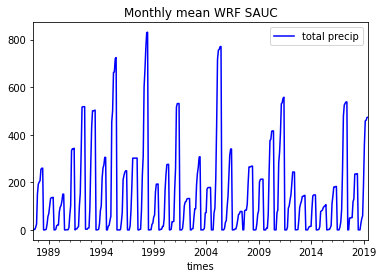

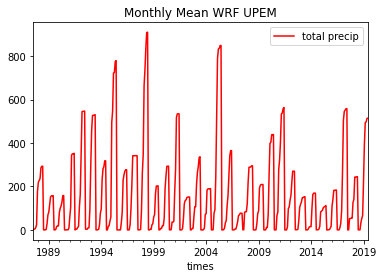

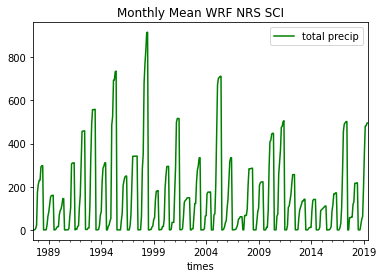

In [18]:
# Precip

plt.figure(figsize=[35,2])
dsauc_mon.plot(color='blue',title='Monthly mean WRF SAUC')
dupem_mon.plot(color='red',title='Monthly Mean WRF UPEM')
dnrs_sci_mon.plot(color='green',title='Monthly Mean WRF NRS SCI')
plt.show()

## Read station monthly means 

In [19]:
data_dir = '/home/patmccornack/data/preprocessed/'
sauc_fname = 'SAUC_monthly_clean.csv'
upem_fname = 'UPEM_monthly_clean.csv'
nrs_sci_fname = 'NRS_SCI_monthly.csv'

osauc = pd.read_csv(os.path.join(data_dir, sauc_fname), index_col='time (PST)')
oupem = pd.read_csv(os.path.join(data_dir, upem_fname), index_col='time (PST)')
onrs_sci = pd.read_csv(os.path.join(data_dir, nrs_sci_fname), index_col='time (PST)')

osauc.index = pd.to_datetime(osauc.index)
oupem.index = pd.to_datetime(oupem.index)
onrs_sci.index = pd.to_datetime(onrs_sci.index)

# Subset to rain cumulative sum for the water year
osauc = osauc[['rain cumsum (mm)']]
oupem = oupem[['rain cumsum (mm)']]
onrs_sci = onrs_sci[['rain cumsum (mm)']]
onrs_sci = onrs_sci.loc['2014-01' : '2019-06-30']  # Cutoff at WRF model end date

In [20]:
osauc.head(2)

,rain cumsum (mm)
time (PST),
2003-12-31,0.6
2004-01-31,1.0


In [21]:
oupem.head(2)

,rain cumsum (mm)
time (PST),
2005-09-30,0.0
2005-10-31,0.0


In [22]:
onrs_sci.head(2)

,rain cumsum (mm)
time (PST),
2014-01-31,0.254
2014-02-28,113.538


## Crop WRF data to observational data
SAUC data spans 2003-12 to 2010-02 (this varies across variables, and has some gaps)

UPEM spans 2005-09 - 2010-09 (varies by variable, has gaps)

NRS SCI spans 2014-01 - present

In [23]:
#### Subset to match Obvervational timeframe ####
dsauc_mon = dsauc_mon.loc['2003-12' : '2010-02']
dupem_mon = dupem_mon.loc['2005-09' : '2010-09']

dnrs_sci_mon = dnrs_sci_mon.loc['2014-01' : '2019-06-30']


## Compare Observational with WRF Model

### Statistics

In [24]:
# This is just to match to original script 
wsauc = dsauc_mon
wupem = dupem_mon
wnrs_sci = dnrs_sci_mon

In [25]:
#### SAUC ####
xval = np.squeeze(osauc.to_numpy())
ymod = np.squeeze(wsauc.to_numpy())
idx = np.where(np.isfinite(xval)) # Observational data is missing values
xval = xval[idx]
ymod = ymod[idx]

res = np.corrcoef(xval, ymod)
corr_sauc = res[0,1]
bias_sauc = (ymod - xval).mean()
tmp = (ymod - xval)**2
rmse_sauc = np.sqrt(tmp.mean())
mabs_sauc = np.abs(ymod - xval).mean()

print('Sauces Canyon')
print(f'Correlation: {corr_sauc}')
print(f'Bias: {bias_sauc}')
print(f'RMSE: {rmse_sauc}')
print(f'MAE: {mabs_sauc}')
      

Sauces Canyon
Correlation: 0.8577080542230736
Bias: 61.65125144221158
RMSE: 125.73450952385699
MAE: 73.60525587084992


In [26]:
#### UPEM ####
xval = np.squeeze(oupem.to_numpy())
ymod = np.squeeze(wupem.to_numpy())
idx = np.where(np.isfinite(xval)) # Observational data is missing values
xval = xval[idx]
ymod = ymod[idx]

res = np.corrcoef(xval, ymod)
corr_upem = res[0,1]
tmp = (ymod - xval)
bias_upem = tmp.mean()
tmp = (ymod - xval)**2
rmse_upem = np.sqrt(tmp.mean())
tmp = np.abs(ymod - xval)
mabs_upem = tmp.mean()

print('Upper Embudo Canyon')
print(f'Correlation: {corr_upem}')
print(f'Bias: {bias_upem}')
print(f'RMSE: {rmse_upem}')
print(f'MAE: {mabs_upem}')
      

Upper Embudo Canyon
Correlation: 0.788809568302139
Bias: -52.770345047264264
RMSE: 118.58143998148707
MAE: 84.36437588811403


In [27]:
#### NRS SCI ####
xval = np.squeeze(onrs_sci.to_numpy())
ymod = np.squeeze(wnrs_sci.to_numpy())
idx = np.where(np.isfinite(xval)) # Observational data is missing values
xval = xval[idx]
ymod = ymod[idx]

res = np.corrcoef(xval, ymod)
corr_nrs_sci = res[0,1]
bias_nrs_sci = (ymod - xval).mean()
tmp = (ymod - xval)**2
rmse_nrs_sci = np.sqrt(tmp.mean())
mabs_nrs_sci = np.abs(ymod - xval).mean()

print('NRS SCI Station')
print(f'Correlation: {corr_nrs_sci}')
print(f'Bias: {bias_nrs_sci}')
print(f'RMSE: {rmse_nrs_sci}')
print(f'MAE: {mabs_nrs_sci}')
      

NRS SCI Station
Correlation: 0.9219420661441837
Bias: -29.154960732983668
RMSE: 73.22785358807393
MAE: 53.97744237558152


## Plot Overlapping Data

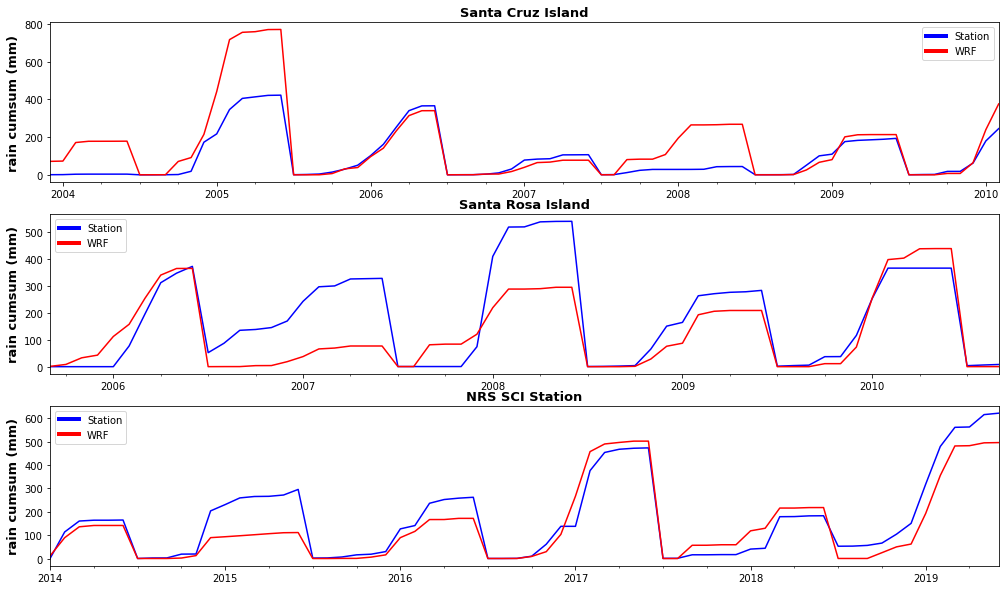

In [28]:
#### Plot data ####

plt.figure(figsize=[17,10])

#### SAUC #####
ax   = plt.subplot(311)
osauc['rain cumsum (mm)'].plot(color='blue')
plt.xlabel('Year',fontsize=13,fontweight='bold')
plt.title('Sauce Canyon',fontweight='bold',fontsize=13)
plt.ylabel('rain cumsum (mm)',fontsize=13,fontweight='bold')
wsauc['total precip'].plot(color='red')
plt.xlabel("")

xp   = 'Corr: ' + str("{:.2f}".format(corr_sauc)) + '   Bias: ' + str("{:.2f}".format(bias_sauc)) + \
'   MABS: ' + str("{:.2f}".format(mabs_sauc))
#plt.text(2000,6,xp,fontsize=13,fontweight='bold')

# Customize legends
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)]
lines        = ax.plot(osauc)
ax.legend(custom_lines, ['Station', 'WRF'])

#### UPEM ####
ax   = plt.subplot(312)
oupem['rain cumsum (mm)'].plot(color='blue')
plt.xlabel('Year',fontsize=13)
plt.title('Upper Embudo Canyon',fontweight='bold',fontsize=13)
plt.ylabel('rain cumsum (mm)',fontweight='bold',fontsize=13)
wupem['total precip'].plot(color='red')
plt.xlabel("")

# Customize legends
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)]
lines        = ax.plot(osauc)
ax.legend(custom_lines, ['Station', 'WRF'])


#### NRS SCI ####
ax   = plt.subplot(313)
onrs_sci['rain cumsum (mm)'].plot(color='blue')
plt.xlabel('Year',fontsize=13)
plt.title('NRS SCI Station',fontweight='bold',fontsize=13)
plt.ylabel('rain cumsum (mm)',fontweight='bold',fontsize=13)
wnrs_sci['total precip'].plot(color='red')

plt.xlabel("")

# Customize legends
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)]
lines        = ax.plot(osauc)
ax.legend(custom_lines, ['Station', 'WRF'])

plt.show()